#ML4Net - Lab 3

## Team members

Marc Mallol 268923 | Jordi Esteve 268829 | Albert Jané 268537

## Description

In this lab, you will train a time series forecaster using Federated Learning (FL).

The dataset you are going to use contains data from multiple APs. In particular, each AP's dataset contains the following features:

* `datetime` is the timestamp (date) at which the measurement was taken
* `Bytes` is the number of Bytes contributed at the corresponding datetime
* `Active Connections` is the number of active connections (users connected to the AP) at the corresponding datetime
* `Active Users` is the number of active users at the corresponding datetime
* `AP ID` is the ID of the AP where the measurement was taken

Original dataset: Chen, W., Lyu, F., Wu, F., Yang, P., & Ren, J. (2021). Flag: Flexible, accurate, and long-time user load prediction in large-scale WiFi system using deep RNN. IEEE Internet of Things Journal, 8(22), 16510-16521.

## Instructions

*   Follow the steps from this Notebook and complete the proposed exercises.
*   Deliver the completed Notebook by uploading it to your Github repository.
*   **Submission deadline: 8 June 2025 (EoB).**

## Setting up the environment

In [24]:
import os
import urllib.request

dataset_url = "https://github.com/fwilhelmi/fwilhelmi.github.io/raw/master/files/datasetLab3.pkl"
dataset_path = "datasetLab3.pkl"

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, dataset_path)
    print("Download complete.")
else:
    print("Dataset already exists:", dataset_path)

Dataset already exists: datasetLab3.pkl


## Loading the data




Load the data from the pickle file (https://docs.python.org/3/library/pickle.html) that contains the dataset.

**Important:** If you have issues with the dataset after automatically downloading and extracting it, download it and move it manually to the indicated folder.

In [25]:
import pickle
import os

print(os.getcwd())
print(os.path.exists('datasetLab3.pkl'))

try:
    with open('datasetLab3.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    print("Data loaded successfully:")
    print(loaded_data)
except FileNotFoundError:
    print("Error: 'datasetLab3.pkl' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

/mnt/c/Users/Marc/Documents/Uni/3r/3r Trimestre/MLNetworks/Labs/ML4Net-2025/Lab3
True
Data loaded successfully:
                     Bytes  Active Connections  Active Users   AP ID
datetime                                                            
2019-04-30 07:10:00    0.0            0.075209           0.0  7-1012
2019-04-30 07:20:00    0.0            0.000000           0.0  7-1012
2019-04-30 07:30:00    0.0            0.000000           0.0  7-1012
2019-04-30 07:40:00    0.0            0.000000           0.0  7-1012
2019-04-30 07:50:00    0.0            0.000000           0.0  7-1012
...                    ...                 ...           ...     ...
2019-05-14 07:10:00    0.0            0.000000           0.0   7-104
2019-05-14 07:20:00    0.0            0.000000           0.0   7-104
2019-05-14 07:30:00    0.0            0.000000           0.0   7-104
2019-05-14 07:40:00    0.0            0.000000           0.0   7-104
2019-05-14 07:50:00    0.0            0.034091           0.0

First we can explore the data before jumping straight to the exercises

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.DataFrame(loaded_data)

display(loaded_data)  

,Bytes,Active Connections,Active Users,AP ID
datetime,,,,
2019-04-30 07:10:00,0.0,0.075209,0.0,7-1012
2019-04-30 07:20:00,0.0,0.000000,0.0,7-1012
2019-04-30 07:30:00,0.0,0.000000,0.0,7-1012
2019-04-30 07:40:00,0.0,0.000000,0.0,7-1012
2019-04-30 07:50:00,0.0,0.000000,0.0,7-1012
...,...,...,...,...
2019-05-14 07:10:00,0.0,0.000000,0.0,7-104
2019-05-14 07:20:00,0.0,0.000000,0.0,7-104
2019-05-14 07:30:00,0.0,0.000000,0.0,7-104


In [27]:
display(df.describe())

,Bytes,Active Connections,Active Users
count,2.110640e+05,211064.000000,211064.000000
mean,3.693131e+04,1.582982,1.200613
std,1.441261e+05,4.446037,3.739401
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000
50%,0.000000e+00,0.000000,0.000000
75%,2.680175e+03,1.353333,1.000000
max,3.993286e+06,103.780000,79.000000


In [28]:
display(df['AP ID'].unique())

array(['7-1012', '7-1013', '7-1021', '7-1043', '7-1019', '7-1071',
       '7-1113', '7-1048', '7-1101', '7-1026', '7-1129', '7-112', '7-100',
       '7-111', '7-1030', '7-1117', '7-1126', '7-1099', '7-1052',
       '7-1087', '7-108', '7-1022', '7-1018', '7-1059', '7-1054', '7-110',
       '7-1058', '7-1094', '7-1064', '7-102', '7-1044', '7-1002',
       '7-1096', '7-1014', '7-1082', '7-1088', '7-1106', '7-1063',
       '7-1114', '7-1137', '7-1004', '7-1045', '7-1125', '7-1036',
       '7-1124', '7-1034', '7-1083', '7-1072', '7-1033', '7-1069',
       '7-1127', '7-1005', '7-1130', '7-1047', '7-1020', '7-1066',
       '7-1039', '7-1134', '7-1003', '7-1120', '7-1131', '7-1009',
       '7-1084', '7-1074', '7-1062', '7-1025', '7-1089', '7-1098',
       '7-1006', '7-1139', '7-10', '7-1133', '7-1060', '7-1032', '7-106',
       '7-1057', '7-101', '7-1102', '7-1085', '7-1053', '7-107', '7-1121',
       '7-1023', '7-1097', '7-1050', '7-1037', '7-11', '7-1136', '7-1040',
       '7-1015', '7-1079'

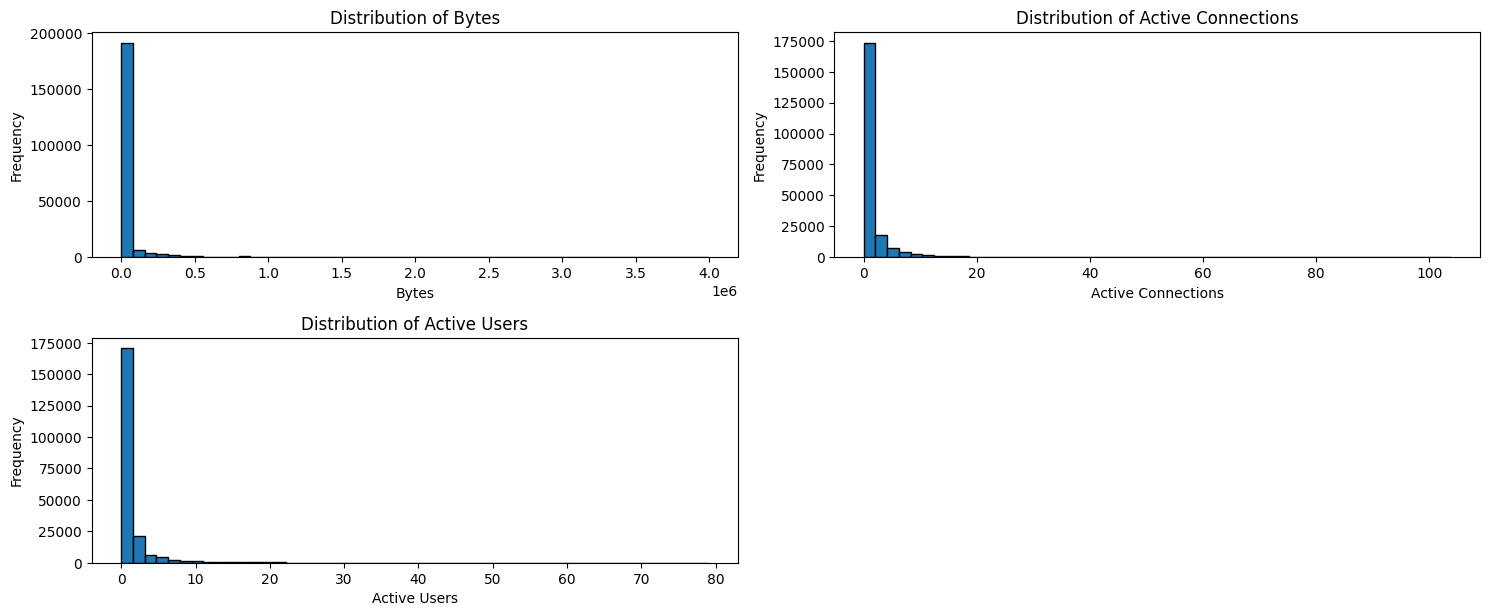

In [29]:
columns_to_plot = [ 'Bytes', 'Active Connections', 'Active Users']

plt.figure(figsize=(15, 15))  # Set the figure size (width, height) in inches

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(5, 2, i)
    plt.hist(df[col], bins=50, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## EXERCISES

### Exercise 1:

Analyze the data from the different APs and discuss their properites (stationarity, trends, seasonality).

Select 2 or 3 key APs showing different properties and generate:

* Line plots (to plot the load vs the time)
* Autocorrelation plots (to show the relationship between past and future samples of the load)
* An Augmented Dickey-Fuller test (to study the stationarity of the AP)



,Bytes,Active Connections,Active Users,AP ID
datetime,,,,
2019-04-30 07:10:00,0.00000,0.075209,0.00,7-1012
2019-04-30 07:20:00,0.00000,0.000000,0.00,7-1012
2019-04-30 07:30:00,0.00000,0.000000,0.00,7-1012
2019-04-30 07:40:00,0.00000,0.000000,0.00,7-1012
2019-04-30 07:50:00,0.00000,0.000000,0.00,7-1012
...,...,...,...,...
2019-05-14 15:30:00,46044.64200,5.000000,3.00,7-1012
2019-05-14 15:40:00,46044.64200,4.753333,3.00,7-1012
2019-05-14 15:50:00,25478.03524,2.660000,1.66,7-1012


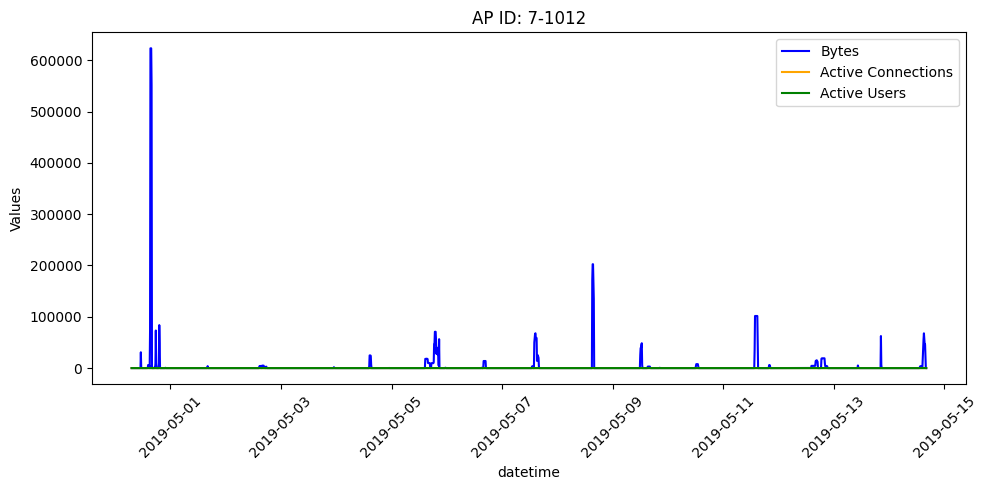

,Bytes,Active Connections,Active Users,AP ID
datetime,,,,
2019-04-29 23:40:00,135931.64300,1.000000,1.000000,7-1013
2019-04-29 23:50:00,135931.64300,1.000000,1.000000,7-1013
2019-04-30 00:00:00,135931.64300,1.000000,1.000000,7-1013
2019-04-30 00:10:00,135931.64300,1.000000,1.000000,7-1013
2019-04-30 00:20:00,135931.64300,1.000000,1.000000,7-1013
...,...,...,...,...
2019-05-14 22:30:00,60.65776,0.106667,0.053333,7-1013
2019-05-14 22:40:00,0.00000,0.000000,0.000000,7-1013
2019-05-14 22:50:00,0.00000,0.000000,0.000000,7-1013


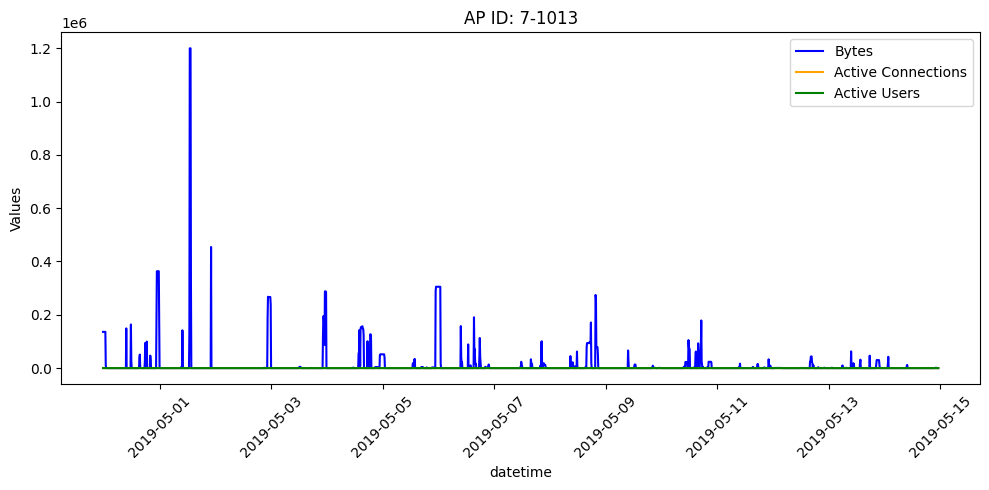

,Bytes,Active Connections,Active Users,AP ID
datetime,,,,
2019-04-30 06:30:00,0.0,0.099010,0.0,7-1021
2019-04-30 06:40:00,0.0,0.000000,0.0,7-1021
2019-04-30 06:50:00,0.0,0.000000,0.0,7-1021
2019-04-30 07:00:00,0.0,0.000000,0.0,7-1021
2019-04-30 07:10:00,0.0,0.000000,0.0,7-1021
...,...,...,...,...
2019-05-14 19:00:00,0.0,0.000000,0.0,7-1021
2019-05-14 19:10:00,0.0,0.000000,0.0,7-1021
2019-05-14 19:20:00,0.0,0.000000,0.0,7-1021


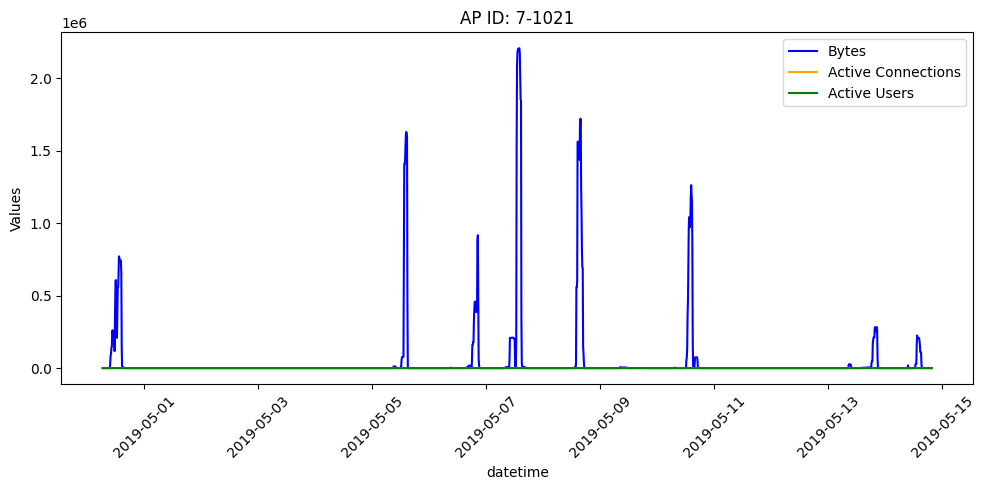

In [30]:
# (response to exercise 1)

selected_APs= df['AP ID'].unique()[:3]  # Select first 3 AP IDs
for ap_id in selected_APs:
    ap_data = df[df['AP ID'] == ap_id]
    display(ap_data)
    plt.figure(figsize=(10, 5))
    plt.plot(ap_data.index, ap_data['Bytes'], label='Bytes', color='blue')
    plt.plot(ap_data.index, ap_data['Active Connections'], label='Active Connections', color='orange')
    plt.plot(ap_data.index, ap_data['Active Users'], label='Active Users', color='green')
    plt.title(f'AP ID: {ap_id}')
    plt.xlabel('datetime')
    plt.ylabel('Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

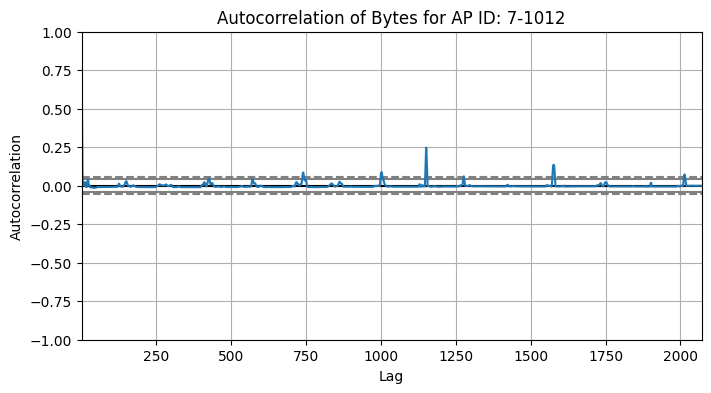

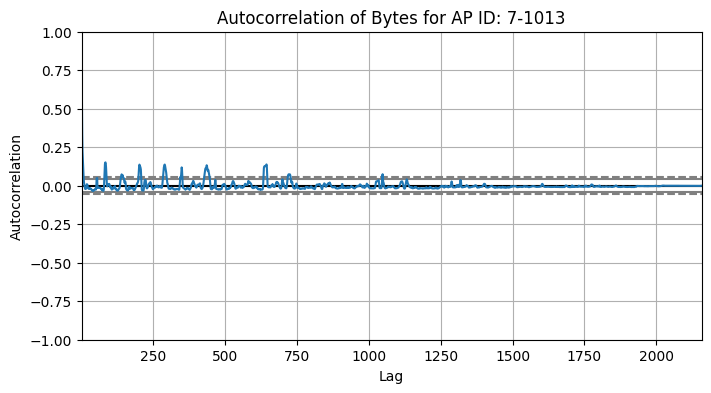

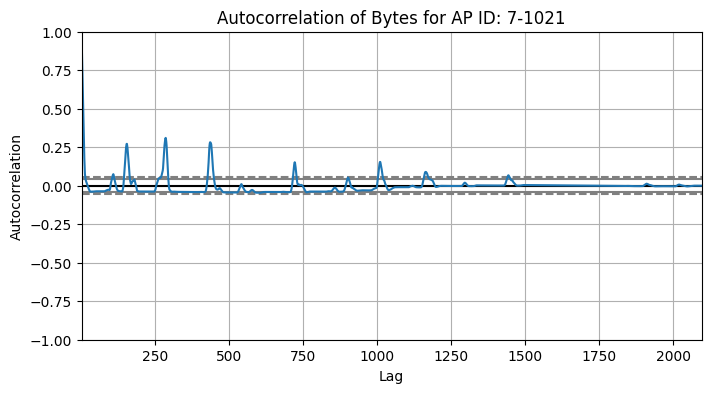

In [31]:
from pandas.plotting import autocorrelation_plot
# Alternatively, for more control:
# from statsmodels.graphics.tsaplots import plot_acf

for ap_id in selected_APs:
    ap_data = df[df['AP ID'] == ap_id]
    plt.figure(figsize=(8, 4))
    autocorrelation_plot(ap_data['Bytes'])
    plt.title(f'Autocorrelation of Bytes for AP ID: {ap_id}')
    plt.show()
    
    # # If you want to use statsmodels for more lags:
    # plot_acf(ap_data['Bytes'], lags=50)
    # plt.title(f'Autocorrelation of Bytes for AP ID: {ap_id}')
    # plt.show()

In [32]:
from statsmodels.tsa.stattools import adfuller

for ap_id in selected_APs:
    ap_data = df[df['AP ID'] == ap_id]
    print(f"\nADF Test for AP ID: {ap_id}")
    result = adfuller(ap_data['Bytes'].dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("=> The series is likely stationary.")
    else:
        print("=> The series is likely non-stationary.")


ADF Test for AP ID: 7-1012
ADF Statistic: -8.0108
p-value: 0.0000
Critical Value 1%: -3.4336
Critical Value 5%: -2.8630
Critical Value 10%: -2.5675
=> The series is likely stationary.

ADF Test for AP ID: 7-1013
ADF Statistic: -14.6033
p-value: 0.0000
Critical Value 1%: -3.4334
Critical Value 5%: -2.8629
Critical Value 10%: -2.5675
=> The series is likely stationary.

ADF Test for AP ID: 7-1021
ADF Statistic: -8.8701
p-value: 0.0000
Critical Value 1%: -3.4335
Critical Value 5%: -2.8629
Critical Value 10%: -2.5675
=> The series is likely stationary.


### Exercise 2:

Prepare the data to be presented as a time series to the ML model. For that, you will have to split features from samples by differentiating between an observation window (e.g., 10 samples) and a prediction window (e.g., 2 samples). Use a sliding window to iterate over all the samples.

Example: For an array [0,1,2,3,4,5], using an observation window $T_o$ = 3 and a prediction window $T_p$ = 1 would lead to the following time series data:
* $x_1$ = [0,1,2], $y_1$ = [3]
* $x_2$ = [1,2,3], $x_2$ = [4]
* $x_3$ = [2,3,4], $y_3$ = [5]

(where x are the features and y the labels)

In [33]:
# Parameters
T_o = 3  # Observation window
T_p = 1   # Prediction window

# Choose features and target columns
feature_cols = ['Bytes', 'Active Connections', 'Active Users']
target_col = 'Bytes'

X_list = []
y_list = []

# Sort by datetime if needed (if index is datetime)
df_sorted = df.sort_index()

for ap_id in df_sorted['AP ID'].unique():
    ap_data = df_sorted[df_sorted['AP ID'] == ap_id]
    ap_data_feat = ap_data[feature_cols].values
    ap_data_target = ap_data[target_col].values
    for i in range(len(ap_data) - T_o - T_p + 1):
        X_list.append(ap_data_feat[i:i+T_o])
        y_list.append(ap_data_target[i+T_o:i+T_o+T_p])

X = np.array(X_list)  # shape: (samples, T_o, num_features)
y = np.array(y_list)  # shape: (samples, T_p)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (210764, 3, 3)
y shape: (210764, 1)


### Exercise 3:

Split the time series data into train, test, and validation, based on your criteria.

In [34]:
# (response to exercise 3)

# We will split the data into training 60%, validation 20%, and test 20% sets.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (126458, 3, 3) (126458, 1)
Validation set shape: (42153, 3, 3) (42153, 1)
Test set shape: (42153, 3, 3) (42153, 1)


### Exercise 4:
Define a model (e.g., GRU, LSTM, CNN, Transformer) able to receive the time series the data you generated in the previous exercise.

In [35]:
# (response to exercise 4)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

def create_lstm_model(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))  # Assuming a single output for regression
    model.compile(optimizer='adam', loss='mse')
    return model

 

2025-06-04 19:05:57.917695: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 19:05:57.926614: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 19:05:57.939229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749056757.968290    7833 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749056757.977990    7833 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749056758.006694    7833 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Exercise 5:

Train your model following two approaches:
1. **Centralized model training:** Mix data from multiple APs to train the model in a centralized fashion.
2. **Federated model training:** Consider APs as independent clients who contribute to training a global model by submitting local model updates.

Show the results by calculating the following metrics from the de-normalized data:
* Mean squared error (MSE)
* Mean absolute error (MAE)
* Mean absolute percentage error (MAPE)

Epoch 1/50


E0000 00:00:1749056761.718018    7833 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1749056761.719498    7833 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/marc/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3952/3952 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 3636279552.0000 - val_loss: 1547382784.0000
Epoch 2/50
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1903754624.0000 - val_loss: 1532141696.0000
Epoch 3/50
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1543717120.0000 - val_loss: 1425126528.0000
Epoch 4/50
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1729927936.0000 - val_loss: 1363542784.0000
Epoch 5/50
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1676027136.0000 - val_loss: 1309355136.0000
Epoch 6/50
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 2060096000.0000 - val_loss: 1371906816.0000
Epoch 7/50
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1502601344.0000 - val_loss: 1499572352.0000
Epoch 8/50
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1526425984.0000 - val_loss: 1787799936.0000
Epoch 9/50
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1517651712.0000 - val_loss: 1468242176.0000
Epoch 10/50
3952/3952 ━━━━━━━━━━━━━━━━━━━━ 20s 5

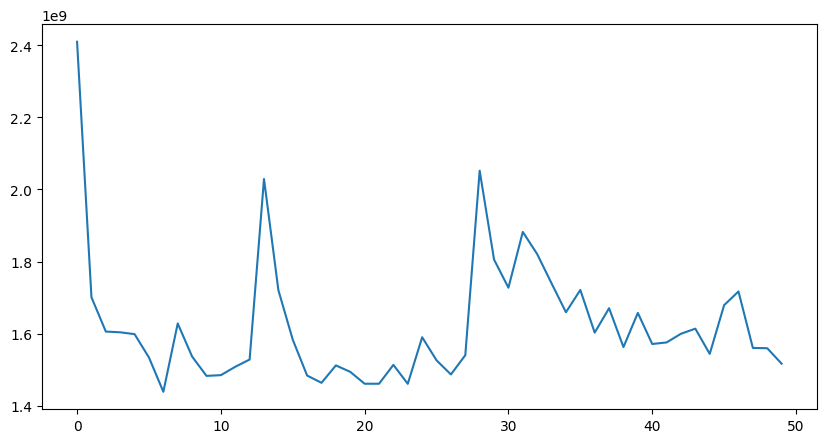

In [ ]:
# (response to exercise 5)

# Create the model centralized around the LSTM architecture
model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")



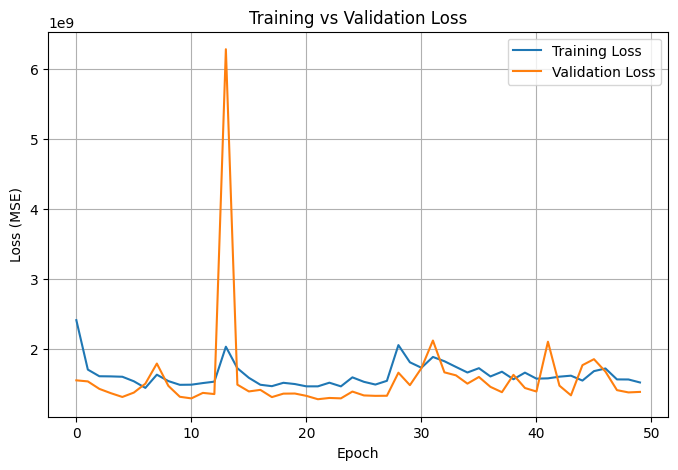

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
from sklearn.metrics import r2_score

# Predict on test set
y_pred = model.predict(X_test)

# If y is 2D (e.g., (samples, T_p)), compute R² for each output
if y_pred.shape[1] == 1 or len(y_pred.shape) == 1:
    r2 = r2_score(y_test, y_pred)
    print(f"R² score: {r2:.4f}")
else:
    for i in range(y_pred.shape[1]):
        r2 = r2_score(y_test[:, i], y_pred[:, i])
        print(f"R² score for output {i}: {r2:.4f}")

1318/1318 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
R² score: 0.9229


### Exercise 6 (EXTRA):

Reconsider your design to improve the accuracy of your model. For that, you can find a better approach to split the data (e.g., using larger observation windows) and include additional features.

In [37]:
# (response to exercise 6)